In [ ]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = r'/content/drive/MyDrive/Final_Project_cdac/BrightningTrain/new_concat_1500'
print('Path:',PATH)

Path: /content/drive/MyDrive/Final_Project_cdac/BrightningTrain/new_concat_1500


In [ ]:
print(os.listdir(PATH+'/new_concat-1500-train'))

['696.png', '175.png', '102.png', '96.png', '663.png', '67.png', '16.png', '677.png', '128.png', '699.png', 'r000da54ft.png', 'r00444b95t.png', 'r002fc3e2t.png', 'r001d260dt.png', 'r005f3e70t.png', 'r00679daet.png', 'r00617aa1t.png', 'r006b0e4bt.png', 'r00816405t.png', 'r00869422t.png', 'r006fcc20t.png', 'r007f5116t.png', 'r00b3931bt.png', 'r00a940e1t.png', 'r00b8d4a2t.png', 'r008a2095t.png', 'r008ed083t.png', 'r00879054t.png', 'r00c0995ft.png', 'r00de2590t.png', 'r0108c383t.png', 'r00d161b7t.png', 'r01170470t.png', 'r010cb248t.png', 'r00c4a543t.png', 'r01058910t.png', 'r012d1dbet.png', 'r01291f20t.png', 'r01474187t.png', 'r012b0f30t.png', 'r0149a21ct.png', 'r01292fd8t.png', 'r0141f0c9t.png', 'r01511e3et.png', 'r0150031ft.png', 'r01559391t.png', 'r015b453ft.png', 'r017904f0t.png', 'r0176fbcat.png', 'r018e74fet.png', 'r019eb1cbt.png', 'r0191aaf4t.png', 'r018ba134t.png', 'r01b3f004t.png', 'r01d9da09t.png', 'r01cbb7fdt.png', 'r01b6aed6t.png', 'r01a5f38at.png', 'r01cf60c7t.png', 'r01c95f68

In [ ]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_png(image)

  w = tf.shape(image)[1]

  w = w // 2
  input_image = image[:, :w, :]
  real_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

(256, 256, 3)


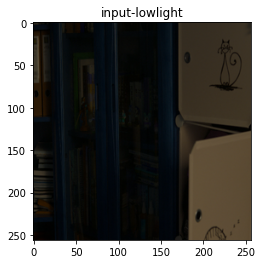

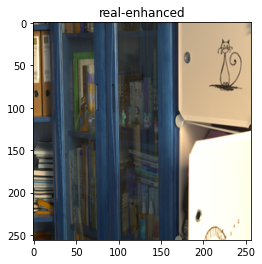

In [ ]:
inp, re = load(PATH+'/new_concat-1500-train/2.png')
# casting to int for matplotlib to show the image
plt.figure()
plt.title('input-lowlight')
plt.imshow(inp/255.0)
plt.figure()
plt.title('real-enhanced')
plt.imshow(re/255.0)
print(inp.shape)

In [ ]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [ ]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [ ]:
# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [ ]:
@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)
  print(input_image.shape)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)
  print('crop',input_image.shape)
  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

(286, 286, 3)
crop (256, 256, 3)


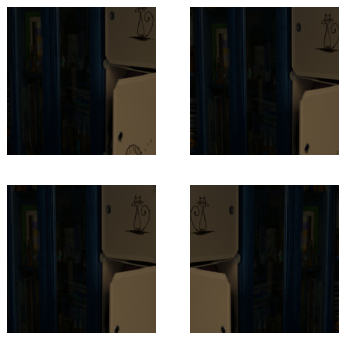

In [ ]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()

In [ ]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
train_dataset = tf.data.Dataset.list_files(PATH+'/new_concat-1500-train/*.png')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

(286, 286, None)
crop (256, 256, 3)


In [ ]:
test_dataset = tf.data.Dataset.list_files(PATH+'/new_concat-1500-test/*.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


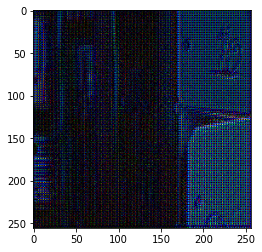

In [ ]:
gen_output = generator(inp[tf.newaxis,...], training=True)
plt.imshow(gen_output[0,...])

In [ ]:
LAMBDA = 115

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

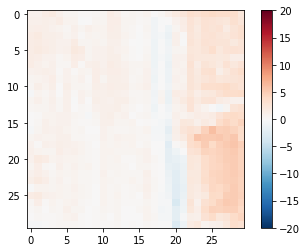

In [ ]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(5e-5, beta_1=0.5)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/Projects_chkp/model_chpts_100_1500BrTrDS_lambda130/training_checkpoints1'

In [ ]:

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

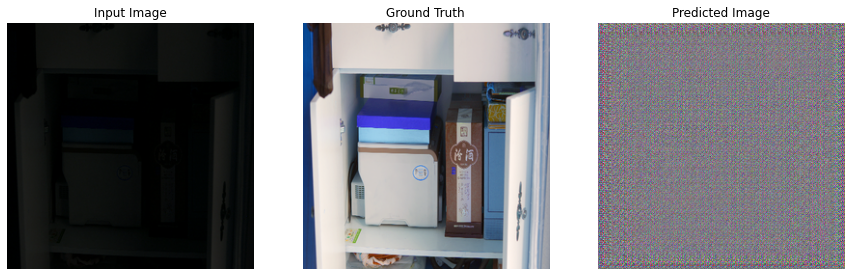

In [ ]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

In [ ]:
EPOCHS = 150

In [ ]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))


  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)
  
  return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss

In [ ]:
def fit(train_ds, epochs, test_ds):
  g_t_loss = []
  g_g_loss = []
  g_l1_loss = []
  d_loss = []
  
  for epoch in range(epochs):
    start = time.time()

    #display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch+1)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      if (n % 10) == 0:
        print('.', end='')
      #if (n+1) % 100 == 0:
        #print()
      gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss = train_step(input_image, target, epoch)
      gen_total_loss_last = float(gen_total_loss)
      gen_gan_loss_last = float(gen_gan_loss) 
      gen_l1_loss_last = float(gen_l1_loss)
      disc_loss_last = float(disc_loss)
    print()
    print(f"gen_total_loss : {gen_total_loss_last}, gen_gan_loss : {gen_gan_loss_last}, gen_l1_loss : {gen_l1_loss_last}, disc_loss : {disc_loss_last}")

    g_t_loss.append(gen_total_loss_last)
    g_g_loss.append(gen_gan_loss_last)
    g_l1_loss.append(gen_l1_loss_last)
    d_loss.append(disc_loss_last)


    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 50 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

  return g_t_loss, g_g_loss, g_l1_loss, d_loss

In [ ]:
g_t_loss, g_g_loss, g_l1_loss, d_loss = fit(train_dataset, EPOCHS, test_dataset)

In [ ]:
# 5 epochs
print(g_t_loss)
print(g_g_loss) 
print(g_l1_loss)
print(d_loss)

[41.38758850097656, 25.78885269165039, 24.758676528930664, 27.702226638793945, 15.463669776916504]
[2.4396040439605713, 1.6865867376327515, 4.370673656463623, 1.8638746738433838, 2.170318841934204]
[0.3894798457622528, 0.24102266132831573, 0.20388002693653107, 0.25838351249694824, 0.13293351233005524]
[0.5622240900993347, 0.7390286326408386, 2.1843323707580566, 0.21261614561080933, 1.0793887376785278]


<function matplotlib.pyplot.show>

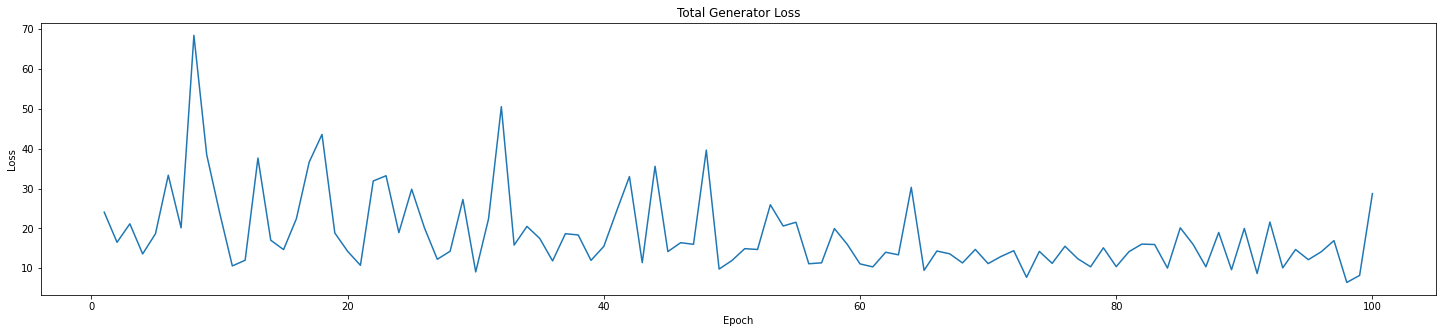

In [ ]:
import numpy as np
e = np.arange(1,151)
plt.figure(figsize=(25,10))

plt.subplot(4,1,1)
plt.plot(e, g_t_loss)
plt.title("Total Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(4,1,2)
plt.plot(e, g_l1_loss)
plt.title("Generator l1 (MAE) Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(4,1,3)
plt.plot(e, g_g_loss)
plt.title("Generator GAN Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(4,1,4)
plt.plot(e, d_loss)
plt.title("Total Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [ ]:
import numpy as np
e = np.arange(1,151)
plt.figure(figsize=(25,5))

plt.plot(e, g_t_loss)
plt.title("Total Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

<function matplotlib.pyplot.show>

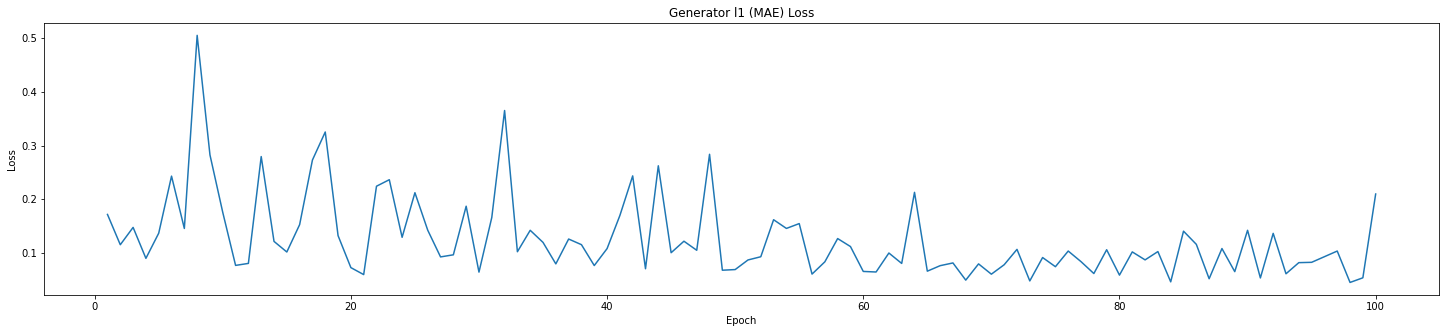

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(e, g_l1_loss)
plt.title("Generator l1 (MAE) Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show

<function matplotlib.pyplot.show>

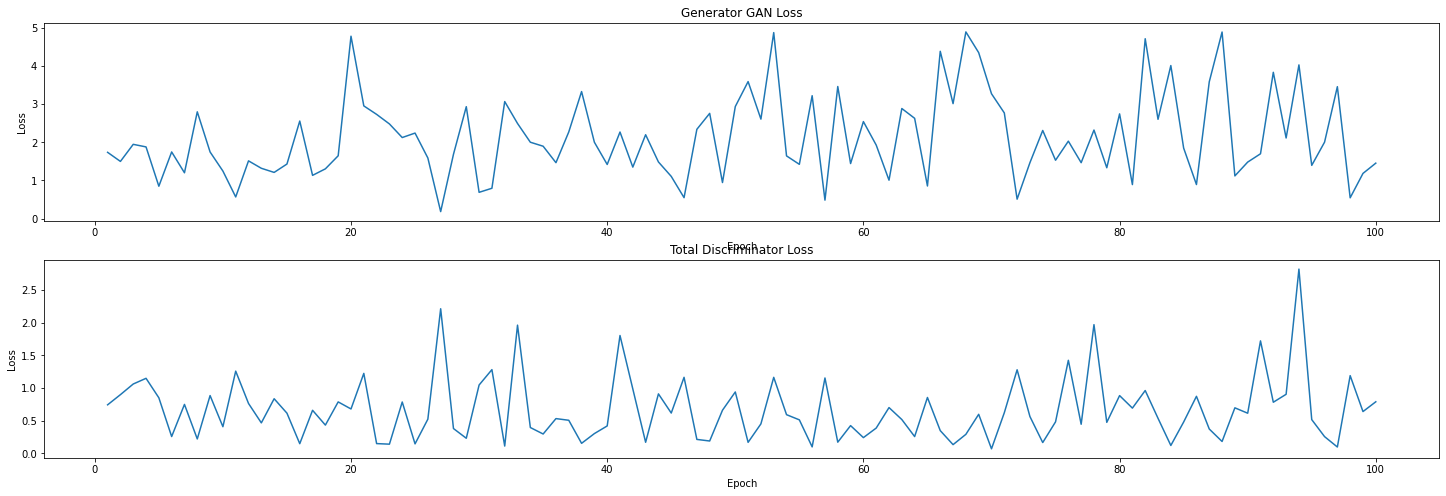

In [ ]:
plt.figure(figsize=(25,8))
plt.subplot(2,1,1)
plt.plot(e, g_g_loss)
plt.title("Generator GAN Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.subplot(2,1,2)
plt.plot(e, d_loss)
plt.title("Total Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show

In [ ]:
#docs_infra: no_execute
%load_ext tensorboard
%tensorboard --logdir {log_dir}

In [ ]:
!ls {checkpoint_dir}

In [ ]:
!pwd {checkpoint_dir}

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

In [ ]:
generator.save("/content/drive/MyDrive/Projects_chkp/model_chpts_100_1500BrTrDS_lambda130/model115_150.h5")

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Projects_chkp/model_chpts_100_1500BrTrDS_lambda130/model115_150.h5")

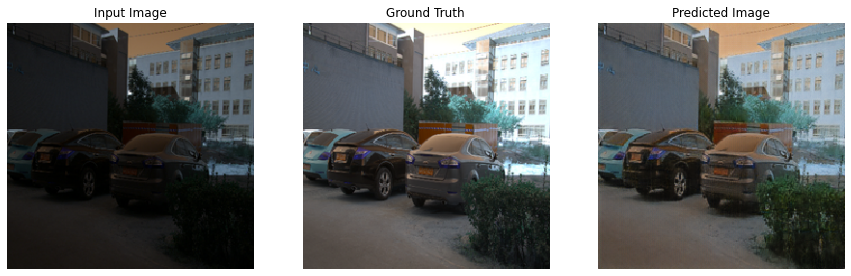

In [ ]:
for inp, tar in train_dataset.take(1):
  generate_images(model, inp, tar)

In [ ]:
for inp, tar in test_dataset.take(5):
  generate_images(model, inp, tar)
  print(inp.shape)